In [46]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from glob import glob
import shutil
import math

In [ ]:
mp_drawing = mp.solutions.drawing_utils #Drawing utilities
mp_holistic = mp.solutions.holistic   #Holistic model

In [ ]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #color conversion
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [ ]:
def draw_landmark(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [ ]:
def draw_styled_landmark(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                                mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                                mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1))
    
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                 mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))
    
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                 mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2))
    
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                 mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2))

In [212]:
cap = cv2.VideoCapture(0) 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        
        # Read the frame
        ret, frame = cap.read()
        
        
        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Drawing landmarks
        draw_styled_landmark(image, results)
        
        cv2.imshow("OpenCV Feed", image)

        if cv2.waitKey(10) and 0xFF == ord("q"):
            break

    cap.release()
    cv2.destroyAllWindows()

error: OpenCV(4.5.5) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [213]:
cap.release()
cv2.destroyAllWindows()

In [ ]:
results.right_hand_landmarks

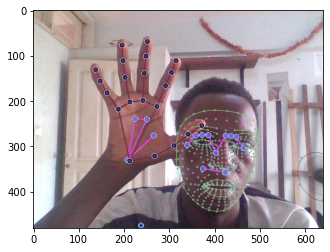

In [139]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [140]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [141]:
len(pose)

33

In [154]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)

In [155]:
len(pose)

132

In [156]:
pose.shape

(132,)

In [157]:
pose.flatten()

array([ 6.29914105e-01,  6.54674411e-01, -9.35972691e-01,  9.99933481e-01,
        6.65573061e-01,  5.76753676e-01, -8.40548337e-01,  9.99888837e-01,
        6.83576822e-01,  5.78524590e-01, -8.40203166e-01,  9.99820352e-01,
        7.00795949e-01,  5.81768215e-01, -8.40245426e-01,  9.99865651e-01,
        6.05496645e-01,  5.74104965e-01, -8.37796807e-01,  9.99905646e-01,
        5.83474278e-01,  5.74371457e-01, -8.36852729e-01,  9.99873042e-01,
        5.61284065e-01,  5.76547027e-01, -8.37101161e-01,  9.99932110e-01,
        7.26109803e-01,  6.32450223e-01, -3.60888422e-01,  9.99776483e-01,
        5.32203913e-01,  6.19373739e-01, -3.14744771e-01,  9.99935329e-01,
        6.63806260e-01,  7.44749129e-01, -7.73878336e-01,  9.99881625e-01,
        5.86657166e-01,  7.27871478e-01, -7.63728738e-01,  9.99930799e-01,
        8.62765431e-01,  1.00350869e+00, -1.95836201e-01,  9.95851040e-01,
        3.72047484e-01,  9.87520576e-01, -2.54626065e-01,  9.99386728e-01,
        9.63795841e-01,  

In [158]:
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)

In [147]:
lh

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [148]:
lh.shape

(63,)

In [149]:
np.zeros(21*3)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [150]:
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [151]:
rh

array([ 3.33918631e-01,  6.92987025e-01,  6.29791430e-07,  4.18755829e-01,
        6.70434237e-01, -4.29195352e-02,  4.87121880e-01,  6.22431040e-01,
       -6.73873425e-02,  5.35919428e-01,  5.70079148e-01, -8.92839953e-02,
        5.82011998e-01,  5.29841244e-01, -1.10564739e-01,  4.27860975e-01,
        4.41710055e-01, -3.97379361e-02,  4.57809776e-01,  3.47520828e-01,
       -6.85641319e-02,  4.76961076e-01,  2.87442446e-01, -9.16189179e-02,
        4.93491888e-01,  2.32577398e-01, -1.08996689e-01,  3.79185051e-01,
        4.14904535e-01, -4.04213853e-02,  3.83501470e-01,  2.90850967e-01,
       -6.60763308e-02,  3.89429986e-01,  2.12410286e-01, -8.70641768e-02,
        3.93834054e-01,  1.44822806e-01, -1.02173254e-01,  3.34054410e-01,
        4.21703070e-01, -4.63046394e-02,  3.18465620e-01,  3.08527887e-01,
       -7.46880844e-02,  3.10477853e-01,  2.32006848e-01, -9.57197249e-02,
        3.06688666e-01,  1.61904037e-01, -1.09460391e-01,  2.93804765e-01,
        4.55408454e-01, -

In [152]:
rh.shape

(63,)

In [ ]:
results.face_landmarks.landmark

In [160]:
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)

In [161]:
face

array([ 0.65441883,  0.78246033, -0.04096232, ...,  0.7524882 ,
        0.61403012,  0.03622947])

In [162]:
face.shape

(1404,)

In [163]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [230]:
def blank_keypoints():
    pose = np.zeros(132)
    face = np.zeros(1404)
    lh = np.zeros(21*3)
    rh = np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [165]:
extract_keypoints(results).shape

(1662,)

# Setup for collecting data

In [166]:
# Path for exported data, numpy array
Data_Path = os.path.join("MP_Data")

#Actions that we try to detect
actions = np.array(["hello", "thanks", "iloveyou"])

#Thirty videos worth of data7
no_sequence = 30

#Videos are going to be 30 frames
sequence_length = 30

## Create a folder for each action for recording its value

In [167]:
for action in actions:
    for sequence in range(no_sequence):
        try:
            os.makedirs(os.path.join(Data_Path, action, str(sequence)))
        except:
            pass

In [203]:
glob("Data/*")

['Data/computer', 'Data/book', 'Data/other']

In [204]:
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

In [238]:
def makedirbyname(path):
    try:
        os.mkdir(path)
    except:
        shutil.rmtree(path)
        os.mkdir(path)

In [220]:
frame_width, frame_height = (256,256)

In [23]:
num_frame_per_video = 100

In [240]:
words = glob("Data/*")
makedirbyname("Data_Numpy")
for word in words:
    videos = glob(word + "/*")
    for video in videos:
        idx = 1
        video_path = "/".join("".join(video.split(".")[0:-1]).split("/")[1:])
        createFolder(f"Data_Numpy/{video_path}")
        print(f"Processing collection for... Data_Numpy/{video_path}")
        try:
            cap = cv2.VideoCapture(video)
            video_frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            print(f"Number of frame = {video_frame_count}")
            with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
                while True:
                    ret, frame = cap.read()

                    if ret == False:
                        cap.release()
                        break
                        
                    #Resize the frame
                    resize_frame = cv2.resize(frame, (frame_width, frame_height))
                    
                    # Make detections
                    image, results = mediapipe_detection(resize_frame, holistic)
                    
                    # Drawing landmarks
                    draw_styled_landmark(image, results)
                    
                    #Extracting keypoints
                    keypoints = extract_keypoints(results)
                    np.save(f"Data_Numpy/{video_path}/{idx}", keypoints)
                    
                    if idx == video_frame_count and video_frame_count < num_frame_per_video:
                        idx+=1
                        while idx<=num_frame_per_video:
                            keypoints_blank = blank_keypoints()
                            np.save(f"Data_Numpy/{video_path}/{idx}", keypoints_blank)
                            idx+=1
                        break
                    elif idx == num_frame_per_video and video_frame_count > num_frame_per_video:
                        break

                    #cv2.imshow(video, image)
                    #print(f"Writing... Data_Numpy/{video_path}/{idx}.png")
                    #cv2.imwrite(f"Data_Numpy/{video_path}/{idx}.png", image)
                    idx+=1

                    if cv2.waitKey(10) and 0xFF == ord("q"):
                        break

                cap.release()
                cv2.destroyAllWindows()
        finally:
            cap.release()
            #cv2.destroyAllWindows()

Processing collection for... Data_Numpy/computer/SignSchool Computer 2-_HHzYqXw-xU
Number of frame = 53
Processing collection for... Data_Numpy/book/book
Number of frame = 75
Processing collection for... Data_Numpy/other/roo
Number of frame = 126
Processing collection for... Data_Numpy/other/6326
Number of frame = 88


In [241]:
cap.release()
#cv2.destroyAllWindows()

In [202]:
cv2.imwrite(f"{idx}.png", frame)

error: OpenCV(4.5.5) /io/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'


In [194]:
video

'Data/other/6326.mp4'

In [198]:
"/".join("".join(video.split(".")[0:-1]).split("/")[1:])

'other/6326'

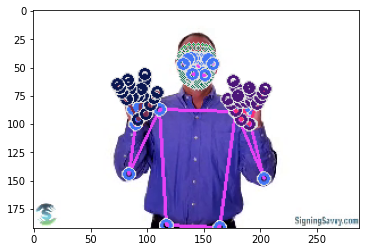

In [215]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [28]:
actions = ["computer", "book", "other"] # Ecrire un script qui récupère tout ça du fichier JSOn

In [29]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [30]:
label_map = {label:num for num,label in enumerate(actions)}

In [32]:
label_map

{'computer': 0, 'book': 1, 'other': 2}

In [45]:
label_map

{'computer': 0, 'book': 1, 'other': 2}

In [56]:
def get_data(train_percent=0.90):
    train_sequences, train_labels = [], []
    test_sequences, test_labels = [], []
    words = glob("Data_Numpy/*")
    for word in words:
        actual_label = word.split("/")[-1]
        videos = glob(word + "/*")
        #print(f"-------------{actual_label}-------")
        train_proportion = math.ceil(round(train_percent * len(videos)))
        for index,video_ in enumerate(videos):
            #print(f"********---> Video   {video_} ----- ")
            window = []
            for frame_num in range(1,num_frame_per_video+1):
                np_file = f"{video_}/{frame_num}.npy"
                #print(np_file)
                res = np.load(np_file)
                window.append(res)
            if index <= train_proportion:
                train_sequences.append(window)
                train_labels.append(label_map[actual_label])
            else:
                test_sequences.append(window)
                test_labels.append(label_map[actual_label])
                
    train_sequences = np.array(train_sequences)
    train_labels = np.array(train_labels)
    test_sequences = np.array(test_sequences)
    test_labels = np.array(test_labels)
                
    return train_sequences, train_labels, test_sequences, test_labels


In [57]:
train_sequences, train_labels, test_sequences, test_labels = get_data(0.5)

In [58]:
train_sequences.shape

(4, 100, 1662)

In [59]:
train_labels.shape

(4,)

In [60]:
test_sequences.shape

(0,)

In [61]:
test_labels.shape

(0,)

In [62]:
X = train_sequences

In [63]:
X.shape

(4, 100, 1662)

In [64]:
y = to_categorical(train_labels).astype(int)

In [65]:
y

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1]])

In [66]:
X_test = test_sequences

In [67]:
X_test

array([], dtype=float64)

In [ ]:
y_test = to_categorical(test_labels).astype(int)